In [1]:
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm




In [5]:
# Загрузка первого CSV файла
df1 = pd.read_csv('train_events.csv')  # замените 'first_file.csv' на имя вашего файла

# Загрузка второго CSV файла
df2 = pd.read_csv('train_targets.csv')  # замените 'second_file.csv' на имя вашего второго файла

# Загрузка третьего CSV файла
df3 = pd.read_csv('video_info_v2.csv')  # замените 'second_file.csv' на имя вашего второго файла

# Объединение данных по полю viewer_uid (внутреннее объединение)
df = pd.merge(df1, df2, on='viewer_uid', how='inner')

# Объединение данных по полю viewer_uid (внутреннее объединение)
df = pd.merge(df, df3, on='rutube_video_id', how='inner')

# Вывод объединенного DataFrame
print(df.head())

# Сохранение объединенных данных в новый CSV файл (если нужно)
df.to_csv('merged_file.csv', index=False)

             event_timestamp                  region ua_device_type  \
0  2024-06-01 06:40:58+03:00             Chelyabinsk        desktop   
1  2024-06-01 19:33:24+03:00  Bashkortostan Republic     smartphone   
2  2024-06-01 21:30:43+03:00          St.-Petersburg        desktop   
3  2024-06-01 23:03:42+03:00                  Moscow     smartphone   
4  2024-06-01 22:48:09+03:00                  Moscow     smartphone   

  ua_client_type    ua_os  ua_client_name  total_watchtime rutube_video_id  \
0        browser  Windows  Yandex Browser             1883    video_133074   
1     mobile app  Android          Rutube              512    video_362960   
2        browser  Windows          Chrome             5647     video_96775   
3     mobile app  Android          Rutube             1521    video_161610   
4     mobile app  Android          Rutube               71    video_116245   

   viewer_uid  age     sex  age_class  \
0    10067243   20  female          0   
1    10245341   40  fe

/tmp/ipykernel_29505/3794297736.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['viewing_hour'] = filtered_df['event_timestamp'].dt.hour


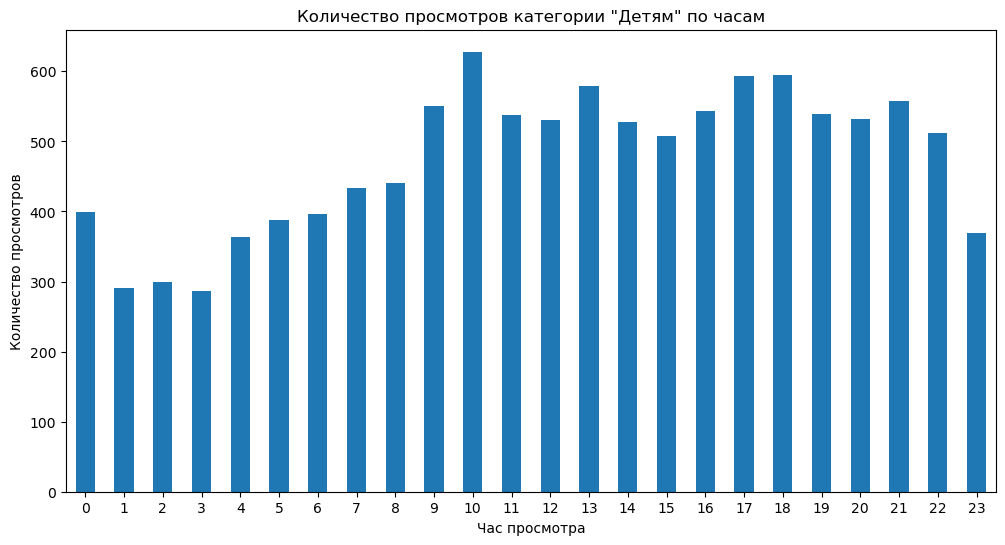

<Figure size 1200x600 with 0 Axes>

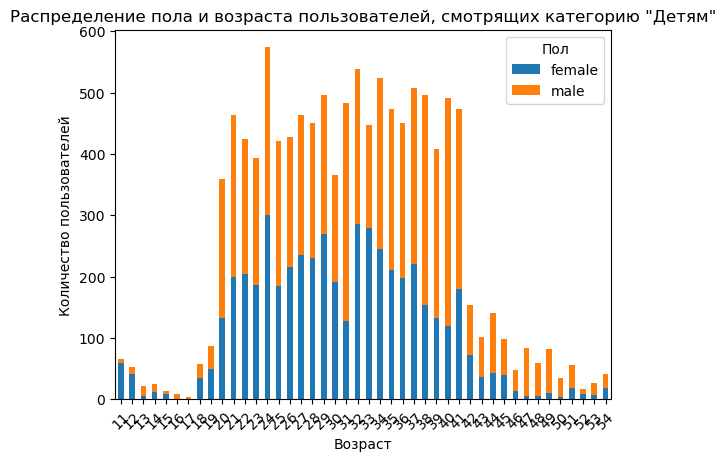

In [11]:
# Преобразование event_timestamp в datetime
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], errors='coerce')

# Фильтрация данных по категории "Детям"
filtered_df = df[df['category'] == "Детям"]

# Извлечение часа просмотра
filtered_df['viewing_hour'] = filtered_df['event_timestamp'].dt.hour

# Подсчет количества просмотров по часам
hour_counts = filtered_df['viewing_hour'].value_counts().sort_index()

# Подсчет распределения по полу и возрасту для категории "Детям"
age_sex_distribution = filtered_df.groupby(['age', 'sex']).size().reset_index(name='counts')

# Визуализация распределения просмотров по часам
plt.figure(figsize=(12, 6))
hour_counts.plot(kind='bar')
plt.title('Количество просмотров категории "Детям" по часам')
plt.xlabel('Час просмотра')
plt.ylabel('Количество просмотров')
plt.xticks(rotation=0)
plt.show()

# Корректное использование pivot
age_sex_distribution_pivot = age_sex_distribution.pivot(index="age", columns="sex", values="counts").fillna(0)

# Визуализация распределения по полу и возрасту
plt.figure(figsize=(12, 6))
age_sex_distribution_pivot.plot(kind='bar', stacked=True)
plt.title('Распределение пола и возраста пользователей, смотрящих категорию "Детям"')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.legend(title='Пол')
plt.show()


In [6]:
df['ua_device_type'] = df['ua_device_type'].astype('category')
df['ua_os'] = df['ua_os'].astype('category')
df['ua_client_name'] = df['ua_client_name'].astype('category')

# Убедимся, что столбец 'sex' содержит категориальные данные (если не так, преобразуем)
df['sex'] = df['sex'].astype('category')

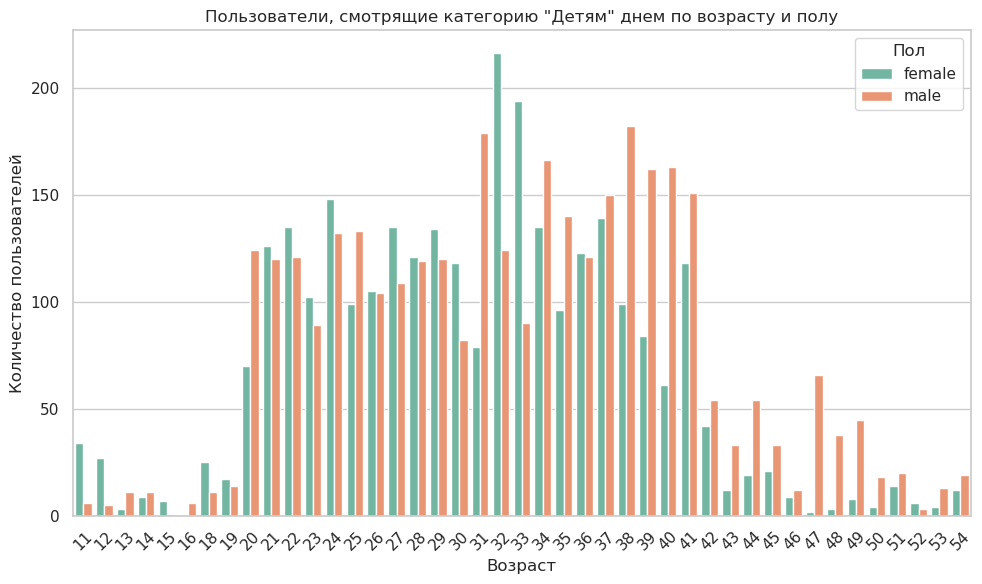

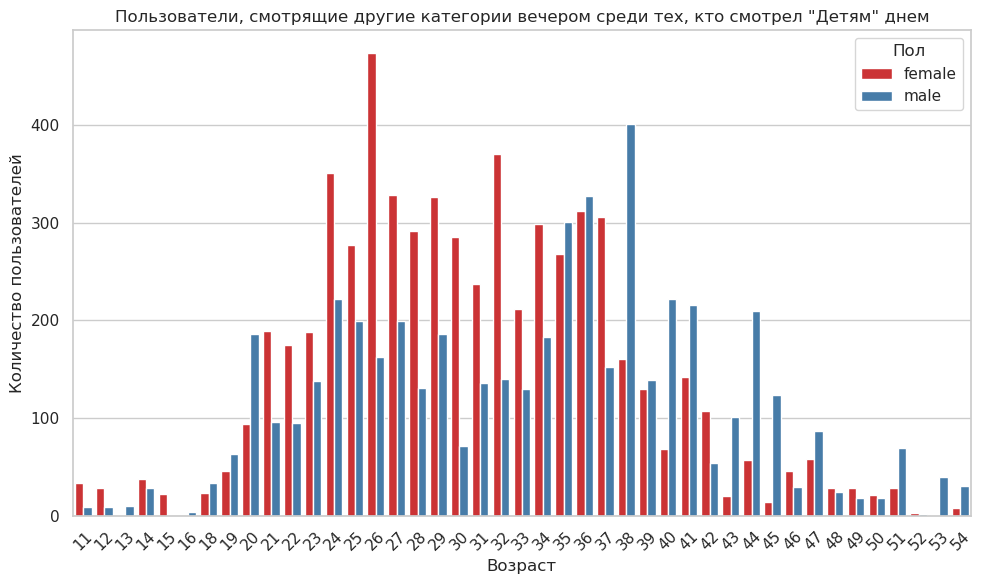

/tmp/ipykernel_29505/2909177115.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="time_of_day", y="age", data=kids_day_df, palette="Pastel1")


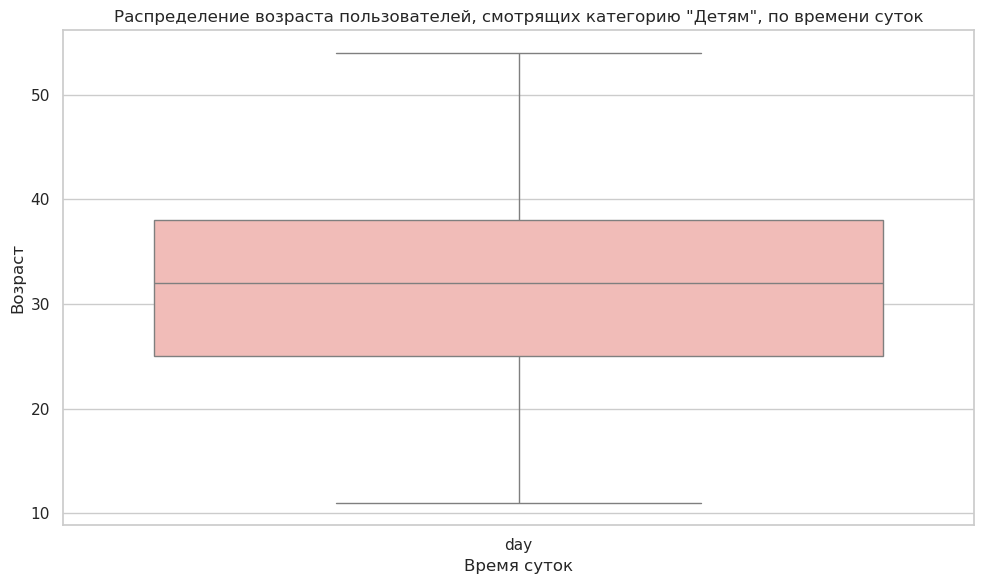

/tmp/ipykernel_29505/2909177115.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="time_of_day", y="age", data=kids_day_df, palette="Set3")


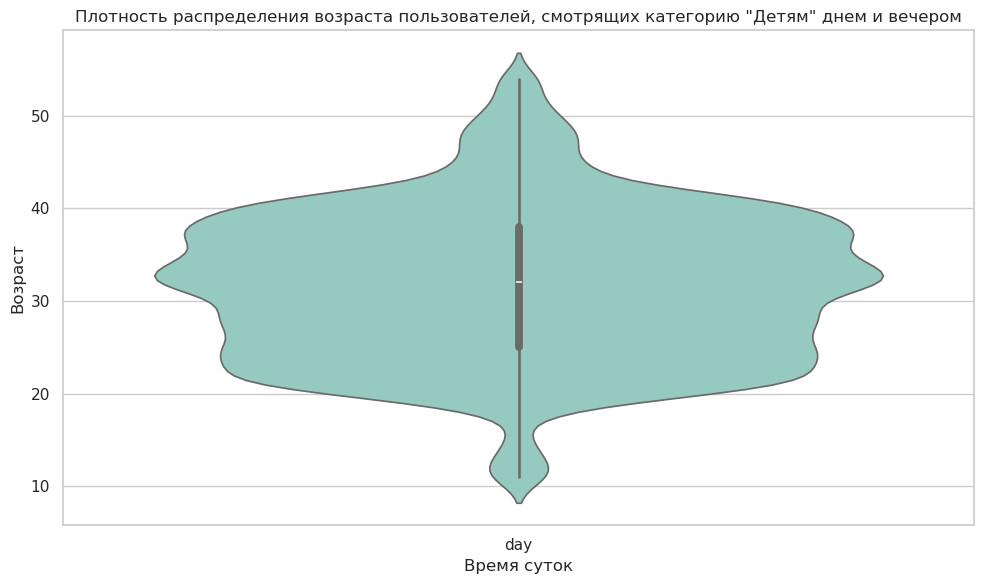

In [15]:
# Преобразование event_timestamp в datetime
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], errors='coerce')

# Извлечение часа просмотра
df['viewing_hour'] = df['event_timestamp'].dt.hour

# Определение времени суток: День: с 6:00 до 18:00
df['time_of_day'] = df['viewing_hour'].apply(lambda x: 'day' if 6 <= x < 18 else 'evening')

# Фильтрация пользователей, смотрящих категорию "Детям" днем
kids_day_df = df[(df['category'] == "Детям") & (df['time_of_day'] == 'day')]

# Получение уникальных идентификаторов пользователей, смотрящих "Детям" днем
kids_day_viewers = kids_day_df['viewer_uid'].unique()

# Фильтрация пользователей, смотрящих другие категории вечером среди тех, кто смотрел "Детям" днем
other_evening_df = df[(df['category'] != "Детям") & (df['time_of_day'] == 'evening') & (df['viewer_uid'].isin(kids_day_viewers))]

# Стиль графиков
sns.set(style="whitegrid")

# Визуализация распределения по возрасту и полу для пользователей, смотрящих "Детям" днем
plt.figure(figsize=(10, 6))
sns.countplot(x="age", hue="sex", data=kids_day_df, palette="Set2")
plt.title('Пользователи, смотрящие категорию "Детям" днем по возрасту и полу')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.legend(title='Пол')
plt.tight_layout()
plt.show()

# Визуализация распределения по возрасту и полу для пользователей, смотрящих другие категории вечером
plt.figure(figsize=(10, 6))
sns.countplot(x="age", hue="sex", data=other_evening_df, palette="Set1")
plt.title('Пользователи, смотрящие другие категории вечером среди тех, кто смотрел "Детям" днем')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.legend(title='Пол')
plt.tight_layout()
plt.show()

# Boxplot для отображения распределения возраста по времени суток для категории "Детям"
plt.figure(figsize=(10, 6))
sns.boxplot(x="time_of_day", y="age", data=kids_day_df, palette="Pastel1")
plt.title('Распределение возраста пользователей, смотрящих категорию "Детям", по времени суток')
plt.xlabel('Время суток')
plt.ylabel('Возраст')
plt.tight_layout()
plt.show()

# Violin Plot для плотности распределения возраста среди тех, кто смотрит "Детям" днем
plt.figure(figsize=(10, 6))
sns.violinplot(x="time_of_day", y="age", data=kids_day_df, palette="Set3")
plt.title('Плотность распределения возраста пользователей, смотрящих категорию "Детям" днем и вечером')
plt.xlabel('Время суток')
plt.ylabel('Возраст')
plt.tight_layout()
plt.show()

Анализ данных показывает, что пользователи в возрасте от 24 до 37 лет часто смотрят категории, предназначенные для детей, в дневное время. Это может свидетельствовать о том, что эти пользователи являются родителями или опекунами, которые используют платформу для просмотра детского контента вместе с детьми в течение дня.

Однако в вечернее время те же пользователи переключаются на другие категории видео. Это указывает на то, что после дневной активности, связанной с просмотром детского контента, они переходят к более взрослым интересам, что подтверждает наличие различных паттернов поведения в зависимости от времени суток.







In [ ]:
# Значимость признаков

In [1]:
# Разберем гипотезу о том что дети пользуются детским контентом с мобильного телефона


/tmp/ipykernel_40798/695519498.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=filtered_importance_df, palette='viridis')


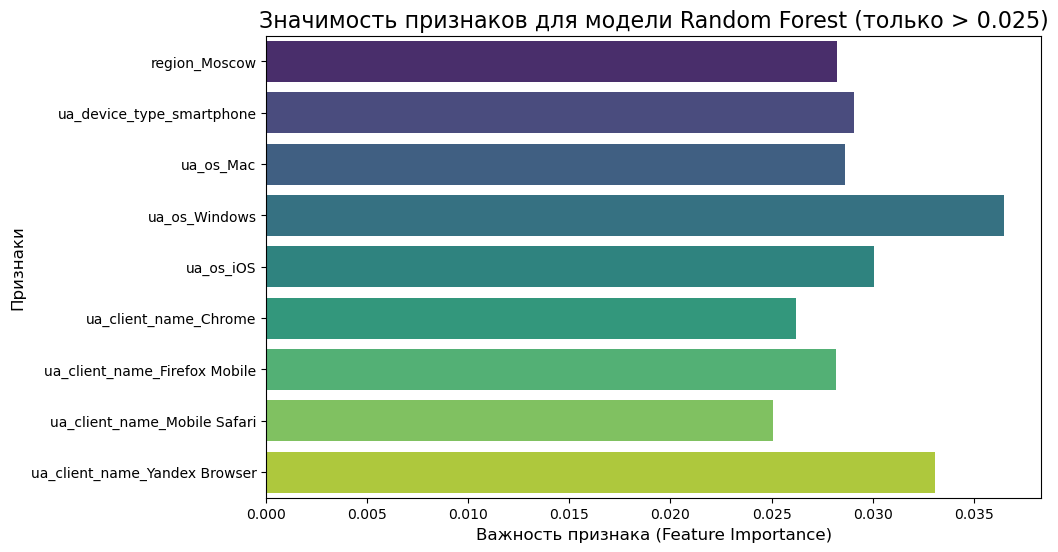

In [14]:
# Преобразуем возраст в категориальные переменные, если это необходимо
# Например, можно разделить возраст на группы (классы)
bins = [0, 18, 25, 35, 45, 55, 65, 100]
labels = ['<18', '18-25', '26-35', '36-45', '46-55', '56-65', '65+']
df['age_class'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Преобразуем категориальные переменные в числовые (one-hot encoding)
X = pd.get_dummies(df[['region', 'ua_device_type', 'ua_client_type', 'ua_os', 'ua_client_name']], drop_first=True)
y = df['age_class'].astype(str)  # Целевая переменная

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем модель RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Оценка значимости признаков
importance = model.feature_importances_

# Создаем DataFrame для значимости признаков
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Фильтруем только признаки с важностью выше 0.025
filtered_importance_df = feature_importance_df[feature_importance_df['Importance'] > 0.025]

# Построение графика значимости признаков с помощью seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=filtered_importance_df, palette='viridis')

# Добавляем заголовок и метки
plt.title('Значимость признаков для модели Random Forest (только > 0.025)', fontsize=16)
plt.xlabel('Важность признака (Feature Importance)', fontsize=12)
plt.ylabel('Признаки', fontsize=12)

# Показываем график
plt.show()


/tmp/ipykernel_40798/2419425644.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=filtered_importance_df, palette='viridis')


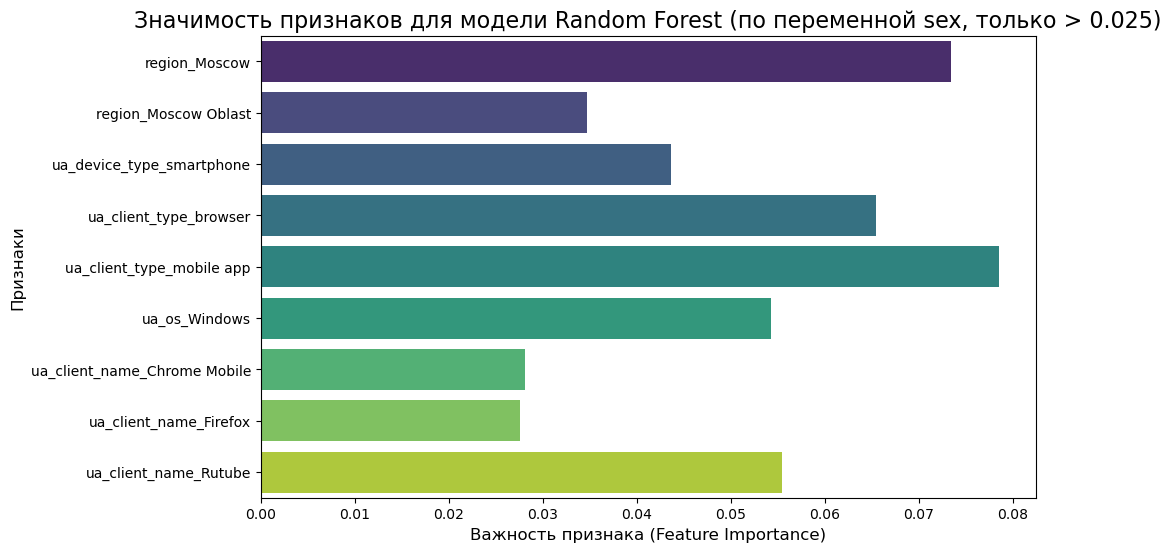

In [28]:
# Преобразуем категориальные переменные в числовые (one-hot encoding)
X = pd.get_dummies(df[['region', 'ua_device_type', 'ua_client_type', 'ua_os', 'ua_client_name']], drop_first=True)
y = df['sex'].astype(str)  # Целевая переменная

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем модель RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Оценка значимости признаков
importance = model.feature_importances_

# Создаем DataFrame для значимости признаков
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
})

# Фильтруем только признаки с важностью выше 0.025
filtered_importance_df = feature_importance_df[feature_importance_df['Importance'] > 0.025]

# Построение графика значимости признаков с помощью seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=filtered_importance_df, palette='viridis')

# Добавляем заголовок и метки
plt.title('Значимость признаков для модели Random Forest (по переменной sex, только > 0.025)', fontsize=16)
plt.xlabel('Важность признака (Feature Importance)', fontsize=12)
plt.ylabel('Признаки', fontsize=12)

# Показываем график
plt.show()